# Ver 1: Valid Output+Random Parameters

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Dict, Tuple, List
import helper
import matplotlib.pyplot as plt

In [2]:


class LinearModelDataset(Dataset):
    def __init__(self, num_samples: int, nr: int, nc: int, dt: float, F: float):
        self.num_samples = num_samples
        self.nr = nr
        self.nc = nc
        self.dt = dt
        self.F = F
        self.samples = self._generate_samples()

    def _generate_samples(self) -> List[Tuple[Dict, torch.Tensor, torch.Tensor, torch.Tensor]]:
        samples = []
        for _ in range(self.num_samples):
            params = {
                'KX': torch.rand(self.nr, self.nc + 1),
                'KY': torch.rand(self.nr + 1, self.nc),
                'DX_C': torch.ones(self.nr, self.nc + 1),
                'DY_C': torch.ones(self.nr + 1, self.nc),
                'DX_G': torch.ones(self.nr + 1, self.nc),
                'DY_G': torch.ones(self.nr, self.nc + 1),
                'VX': torch.randn(self.nr, self.nc + 1) * 100,
                'VY': torch.randn(self.nr + 1, self.nc) * 100,
                'RAC': torch.ones(self.nr, self.nc),
                'f': torch.randn(self.nr * self.nc),
            }
            
            x_t = torch.randn(self.nr * self.nc)
            lambda_t_plus_1 = torch.randn(self.nr * self.nc)
            dx_dt_lambda = self._compute_dx_dt_lambda(params, x_t, lambda_t_plus_1)
            
            samples.append((params, x_t, lambda_t_plus_1, dx_dt_lambda))
        
        return samples

    def _compute_dx_dt_lambda(self, 
                          params: Dict[str, torch.Tensor], 
                          x_t: torch.Tensor, 
                          lambda_t_plus_1: torch.Tensor) -> torch.Tensor:
        """
        Compute dx(t+1)/dx(t) * lambda(t+1) for the linear model
        
        For our linear model, dx(t+1)/dx(t) = M.T, where M is our model matrix.
        We can get M from helper.py's make_M_2d_diffusion_advection_forcing function.
        
        Args:
        params: Dictionary containing model parameters (KX, KY, etc.)
        x_t: Current state vector (not used since model is linear)
        lambda_t_plus_1: Adjoint variable at next timestep
        
        Returns:
        torch.Tensor: M.T @ lambda(t+1)
        """
        # Convert PyTorch tensors to numpy arrays for helper function
        np_params = {
            key: tensor.cpu().detach().numpy() if torch.is_tensor(tensor) else tensor
            for key, tensor in params.items()
        }
        
        # Get model matrix M using helper function
        M = helper.make_M_2d_diffusion_advection_forcing(
            nr=self.nr,
            nc=self.nc,
            dt=self.dt,  # Using class dt parameter
            KX=np_params['KX'],
            KY=np_params['KY'],
            DX_C=np_params['DX_C'],
            DY_C=np_params['DY_C'], 
            DX_G=np_params['DX_G'],
            DY_G=np_params['DY_G'],
            VX=np_params['VX'],
            VY=np_params['VY'],
            RAC=np_params['RAC'],
            F=self.F,  # Using class F parameter
            cyclic_east_west=True,
            cyclic_north_south=False,
            M_is_sparse=False  # Using dense matrix for PyTorch compatibility
        )
        
        # Convert to numpy arrays and do matrix multiplication
        lambda_np = lambda_t_plus_1.cpu().detach().numpy()
        result_np = M.T @ lambda_np
        
        # Convert back to PyTorch tensor
        return torch.from_numpy(result_np).float()

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int) -> Tuple[Dict[str, torch.Tensor], torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.samples[idx]

class LinearModelNet(torch.nn.Module):
    def __init__(self, nr: int, nc: int):
        super().__init__()
        self.nr = nr
        self.nc = nc
        
        self.state_size = nr * nc
        self.param_size = (nr * (nc + 1) +
                           (nr + 1) * nc +
                           nr * (nc + 1) +
                           (nr + 1) * nc +
                           (nr + 1) * nc +
                           nr * (nc + 1) +
                           nr * (nc + 1) +
                           (nr + 1) * nc +
                           nr * nc +
                           nr * nc)
        
        self.input_size = self.state_size * 2 + self.param_size
        self.output_size = nr * nc
        
        print(f"Input size: {self.input_size}")
        
        # Adjust the architecture to handle the correct input size
        self.fc1 = torch.nn.Linear(self.input_size, 2048)
        self.fc2 = torch.nn.Linear(2048, 1024)
        self.fc3 = torch.nn.Linear(1024, 512)
        self.fc4 = torch.nn.Linear(512, self.output_size)
        
        self.activation = torch.nn.ReLU()
        
    def forward(self, x: torch.Tensor, lambda_t_plus_1: torch.Tensor, params: Dict[str, torch.Tensor]) -> torch.Tensor:
        batch_size = x.size(0) 
        
        # Ensure all tensors have the correct batch size
        x = x.view(batch_size, -1)
        lambda_t_plus_1 = lambda_t_plus_1.view(batch_size, -1)
        
        # Flatten the params dictionary
        params_flat = torch.cat([param.view(batch_size, -1) for param in params.values()], dim=1)
        
        # Concatenate all inputs
        x = torch.cat([x, lambda_t_plus_1, params_flat], dim=1)
        
        # Add some debugging print statements
        #print(f"x shape: {x.shape}")
        #print(f"Input size: {self.input_size}")
        
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        
        return x

def train_model(model: torch.nn.Module, dataloader: DataLoader, num_epochs: int, learning_rate: float):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for params, x_t, lambda_t_plus_1, dx_dt_lambda in dataloader:
            optimizer.zero_grad()
            output = model(x_t, lambda_t_plus_1, params)
            loss = criterion(output, dx_dt_lambda)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")



Creating datasets...
Input size: 1280
Training started...
Epoch 1/10
Training Loss: 589.2978
Test Loss: 594.2795
Epoch 2/10
Training Loss: 583.3064
Test Loss: 596.0448
Epoch 3/10
Training Loss: 574.3052
Test Loss: 598.2393
Epoch 4/10
Training Loss: 559.9221
Test Loss: 605.7100
Epoch 5/10
Training Loss: 537.3827
Test Loss: 618.2603
Epoch 6/10
Training Loss: 513.2783
Test Loss: 627.2131
Epoch 7/10
Training Loss: 483.8281
Test Loss: 639.9155
Epoch 8/10
Training Loss: 452.7082
Test Loss: 653.7474
Epoch 9/10
Training Loss: 420.7155
Test Loss: 667.5577
Epoch 10/10
Training Loss: 391.7737
Test Loss: 669.7842
Training complete!


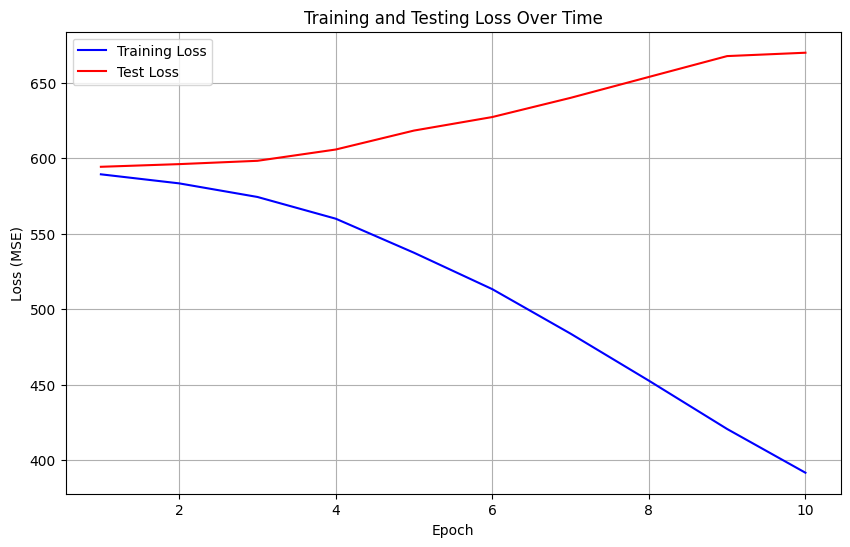


Comparison of first 10 values (from test set):
Index    True Value    Predicted   Difference
--------------------------------------------
0        -16.669193    -8.835766    -7.833427
1          0.179150     3.387760    -3.208611
2          9.910766    11.157840    -1.247074
3        -20.518776   -17.046894    -3.471882
4          2.282046    -0.235884     2.517930
5        -18.500217     2.676137   -21.176355
6        -32.902332   -12.843062   -20.059269
7          7.909690    -8.518322    16.428013
8         -9.707729     7.165646   -16.873375
9         12.255885    -3.285130    15.541016

Test Set Statistics:
Mean Absolute Error: 16.278416
Root Mean Square Error: 23.227482
True vector norm: 229.609955
Predicted vector norm: 78.280060


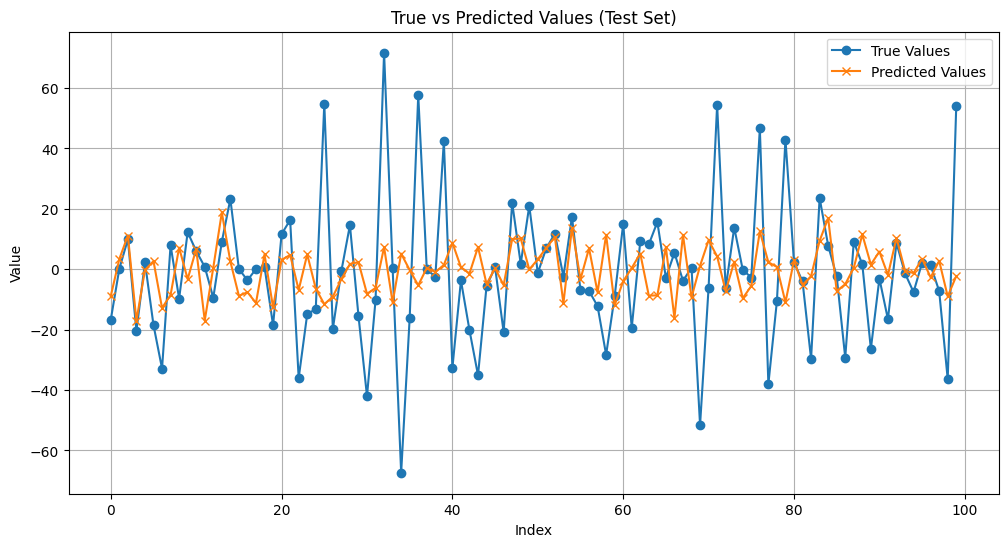

In [ ]:
if __name__ == "__main__":
    # Model parameters
    nr, nc = 10, 10
    dt = 0.1
    F = 1.0
    
    # Dataset parameters
    train_samples = 1800  # 90% for training
    test_samples = 200    # 10% for testing
    batch_size = 320
    num_epochs = 10
    learning_rate = 0.001

    print("Creating datasets...")
    # Create datasets
    train_dataset = LinearModelDataset(train_samples, nr, nc, dt, F)
    test_dataset = LinearModelDataset(test_samples, nr, nc, dt, F)
    
    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create and train the model
    model = LinearModelNet(nr, nc)
    
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    # Lists to store losses for plotting
    train_losses = []
    test_losses = []
    
    print("Training started...")
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for params, x_t, lambda_t_plus_1, dx_dt_lambda in train_dataloader:
            optimizer.zero_grad()
            output = model(x_t, lambda_t_plus_1, params)
            loss = criterion(output, dx_dt_lambda)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for params, x_t, lambda_t_plus_1, dx_dt_lambda in test_dataloader:
                output = model(x_t, lambda_t_plus_1, params)
                test_loss = criterion(output, dx_dt_lambda)
                total_test_loss += test_loss.item()
        
        # Store average losses
        avg_train_loss = total_train_loss/len(train_dataloader)
        avg_test_loss = total_test_loss/len(test_dataloader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Test Loss: {avg_test_loss:.4f}")
    
    print("Training complete!")

    # Plot training and testing losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, 'r-', label='Test Loss')
    plt.title('Training and Testing Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test examples
    model.eval()
    test_params, test_x, test_lambda, test_true = next(iter(test_dataloader))
    
    # Get model prediction for first test example
    with torch.no_grad():
        predicted = model(test_x[0:1], test_lambda[0:1], 
                        {k: v[0:1] for k, v in test_params.items()})

    # Remove batch dimension
    predicted = predicted.squeeze(0)
    test_true = test_true[0]  # Get first example's true values

    # Print comparison
    print(f"\nComparison of first 10 values (from test set):")
    print(f"{'Index':<6} {'True Value':>12} {'Predicted':>12} {'Difference':>12}")
    print("-" * 44)
    for i in range(10):
        print(f"{i:<6} {test_true[i]:>12.6f} {predicted[i]:>12.6f} {(test_true[i] - predicted[i]):>12.6f}")

    # Print overall statistics
    print(f"\nTest Set Statistics:")
    print(f"Mean Absolute Error: {torch.abs(test_true - predicted).mean():.6f}")
    print(f"Root Mean Square Error: {torch.sqrt(torch.mean((test_true - predicted)**2)):.6f}")
    print(f"True vector norm: {torch.norm(test_true):.6f}")
    print(f"Predicted vector norm: {torch.norm(predicted):.6f}")

    # Plot true vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(test_true.numpy(), label='True Values', marker='o')
    plt.plot(predicted.numpy(), label='Predicted Values', marker='x')
    plt.title('True vs Predicted Values (Test Set)')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

### To-do:

- Instead of random data, get data from actual climate simulation examples
- Train model on only one world
- Train model on many worlds